In [1]:
import os
os.environ['DT'] = '1'
os.environ['NX'] = '16'          if 'CI' not in os.environ else '10'
os.environ['N_STEPS'] = '64'     if 'CI' not in os.environ else '2'
os.environ['N_ITERS'] = '3'      if 'CI' not in os.environ else '1'
os.environ['N_REPEATS'] = '4'    if 'CI' not in os.environ else '1'
os.environ['MAX_THREADS'] = '3'  if 'CI' not in os.environ else '2'

figsize = (4.5, 5)
linewidth = 1.5

In [2]:
import subprocess
import sys
import json
import numpy as np
import numba
import matplotlib
from matplotlib import pyplot
from open_atmos_jupyter_utils import show_plot

### 0. compilation of libmpdata++-based solver

In [3]:
%%writefile CMakeLists.txt
cmake_minimum_required(VERSION 3.18)
project(revolving_sphere_3d CXX)
find_package(libmpdata++)
set(CMAKE_CXX_FLAGS "${CMAKE_CXX_FLAGS} ${libmpdataxx_CXX_FLAGS_RELEASE}")
add_executable(revolving_sphere_3d revolving_sphere_3d.cpp)
target_link_libraries(revolving_sphere_3d ${libmpdataxx_LIBRARIES})
target_include_directories(revolving_sphere_3d PUBLIC ${libmpdataxx_INCLUDE_DIRS})

Writing CMakeLists.txt


In [4]:
%%writefile revolving_sphere_3d.cpp
/**
 * based on tests:tests/paper_2015_GMD/4_revolving_sphere_3d/revolving_sphere_3d.cpp
 * @copyright University of Warsaw
 * @section LICENSE
 * GPLv3+ (see the COPYING file or http://www.gnu.org/licenses/)
 */

#include <boost/math/constants/constants.hpp>
using boost::math::constants::pi;

#include <libmpdata++/solvers/mpdata.hpp>
#include <libmpdata++/concurr/threads.hpp>
using namespace libmpdataxx;

void test(const double dt, const int nx, const int nt, const int n_iters)
{
  enum {x, y, z};
  struct ct_params_t : ct_params_default_t
  {
    using real_t = double;
    enum { n_dims = 3 };
    enum { n_eqns = 1 };
    enum { opts = 0 };
  };

  using slv_t = solvers::mpdata<ct_params_t>;
  typename slv_t::rt_params_t p;

  // pre instantation
  p.n_iters = n_iters;
  p.grid_size = {nx, nx, nx};

  // post instantation
  const typename ct_params_t::real_t
    L = 100,
    dx = L / (nx - 1),
    dy = dx,
    dz = dx,
    h = 4,
    r = 15,
    d = 25 / sqrt(3),
    x0 = 50 - d,
    y0 = 50 + d,
    z0 = 50 + d;
  
  p.di = dx;
  p.dj = dy;
  p.dk = dz;
  p.dt = dt;

  // instantation
  concurr::threads<
    slv_t,
    bcond::open, bcond::open,
    bcond::open, bcond::open,
    bcond::open, bcond::open
  > slv(p);

  blitz::firstIndex i;
  blitz::secondIndex j;
  blitz::thirdIndex k;

  // sphere shape
  decltype(slv.advectee()) tmp(slv.advectee().extent());
  tmp.reindexSelf(slv.advectee().base());
  tmp =   blitz::pow(i * dx - x0, 2)
        + blitz::pow(j * dx - y0, 2)
        + blitz::pow(k * dx - z0, 2);
  slv.advectee() = where(tmp - pow(r, 2) <= 0, h, 0);

  const typename ct_params_t::real_t
    omega = 0.1,
    xc = 50,
    yc = 50,
    zc = 50;

  // constant angular velocity rotational field
  slv.advector(x) = omega / sqrt(3) * (-(j * dy - yc) + (k * dz - zc)) * dt / dx;
  slv.advector(y) = omega / sqrt(3) * ( (i * dx - xc) - (k * dz - zc)) * dt / dy;
  slv.advector(z) = omega / sqrt(3) * (-(i * dx - xc) + (j * dy - yc)) * dt / dz;

  // time stepping
  slv.advance(nt);
}

int main(int argc, char **argv)
{
  assert(argc == 5);
  test(
    atof(std::getenv("DT")),
    atoi(std::getenv("NX")),
    atoi(std::getenv("N_STEPS")),
    atoi(std::getenv("N_ITERS"))
  );
}

Writing revolving_sphere_3d.cpp


In [5]:
if sys.platform == 'linux':
    _ = subprocess.run(
        ["bash", "-c", "mkdir -p build; cd build; cmake ..; make; cd .."],
        check=True
    )

-- Detecting if the compiler is an MPI wrapper...
-- Detecting if the compiler is an MPI wrapper... - FALSE
-- gnuplot-iostream not found.

* Programs using libmpdata++'s gnuplot-iostream output will not compile.
* To install gnuplot-iostream, please try:
*   Debian/Ubuntu: sudo apt-get install libgnuplot-iostream-dev
*   manual: wget -O /usr/local/include/gnuplot-iostream.h https://raw.githubusercontent.com/dstahlke/gnuplot-iostream/master/gnuplot-iostream.h
  
-- Configuring done
-- Generating done
-- Build files have been written to: /home/slayoo/devel/PyMPDATA-examples/PyMPDATA_examples/Bartman_et_al_2022/build
Scanning dependencies of target revolving_sphere_3d
[ 50%] Building CXX object CMakeFiles/revolving_sphere_3d.dir/revolving_sphere_3d.cpp.o
[100%] Linking CXX executable revolving_sphere_3d
[100%] Built target revolving_sphere_3d


### 1. scaling with number of threads

In [6]:
data_th_libmpdata = {}
if sys.platform == 'linux':
    for n_thread in range(1, int(os.environ['MAX_THREADS'])+1):
        value = np.inf
        for _ in range(int(os.environ['N_REPEATS'])):
            info = subprocess.run(
                ["build/revolving_sphere_3d"],
                capture_output=True,
                check=True,
                env={**os.environ, "OMP_NUM_THREADS": str(n_thread)}
            )
            if info.returncode != 0:
                print(info)
                assert False
            value = min(value, float(str(info.stderr).split(" ")[3][:-1]))
        data_th_libmpdata[str(n_thread)] = value / int(os.environ['N_STEPS'])
print(data_th_libmpdata)

{'1': 0.0014762890625, '2': 0.000791353125, '3': 0.0005743859375}


In [7]:
%%writefile revolving_sphere_3d.py
import timeit
import json
import os
import numpy as np
import numba
from PyMPDATA import Options
from PyMPDATA_examples.Smolarkiewicz_1984 import Settings, Simulation

def run_simulation(*, static, n_threads, nx, dt, nt):
    settings = Settings(n=nx, dt=dt)
    options = Options(n_iters=int(os.environ['N_ITERS']))
    simulation = Simulation(settings, options, static=static, n_threads=n_threads)
    _ = simulation.run(nt=nt)

def time_pympdata(*, static, n_threads, nx, dt, nt, repeat):
    cmd = f"run_simulation(static={static}, n_threads={n_threads}, nx={nx}, dt={dt}, nt={nt})"
    time_init = min(timeit.repeat(
        cmd.replace(f"nt={nt}", "nt=1"),
        globals=globals(),
        number=1,
        repeat=repeat
    ))
    time_full = min(timeit.repeat(
        cmd,
        globals=globals(),
        number=1,
        repeat=repeat
    ))
    return (time_full - time_init) / (nt - 1)

if __name__ == '__main__':
    ticks = range(1, int(os.environ['MAX_THREADS'])+1) \
        if os.environ["NUMBA_DISABLE_JIT"] != '1' \
        else (1,)

    if os.environ["NUMBA_DISABLE_JIT"] == '1':
        with np.errstate(all="ignore"):
            data = {'nojit': time_pympdata(
                static=False,
                n_threads=1,
                nx=int(os.environ['NX']),
                dt=float(os.environ['DT']),
                nt=int(os.environ['N_STEPS']),
                repeat=2
            )}
    else:
        data = {
            'static': {i:-1 for i in ticks},
            'dynamic': {i:-1 for i in ticks},
        }
        for _n_threads in ticks:
            numba.set_num_threads(_n_threads)
            print(f'n_threads={_n_threads}')
            for grid, flag in {'static': True, 'dynamic': False}.items():
                data[grid][_n_threads] = time_pympdata(
                    static=flag,
                    n_threads=_n_threads,
                    nx=int(os.environ['NX']),
                    dt=float(os.environ['DT']),
                    nt=int(os.environ['N_STEPS']),
                    repeat=int(os.environ['N_REPEATS'])
                )

    with open(f'data_NDJ={os.environ["NUMBA_DISABLE_JIT"]}.json', 'w', encoding="utf-8") as file:
        json.dump(data, file)

Writing revolving_sphere_3d.py


In [8]:
for ndj in ('0', '1'):
    info = subprocess.run(
        [sys.executable, "revolving_sphere_3d.py"],
        capture_output=True,
        check=True,
        env={**os.environ, 'NUMBA_DISABLE_JIT': ndj}
    )
    if info.returncode != 0:
        print(info)
        assert False
data_th_pympdata = {}
for ndj in ('0', '1'):
    with open(f'data_NDJ={ndj}.json', 'r', encoding="utf-8") as file:
        for k, v in json.load(file).items():
            data_th_pympdata[k] = v
print(data_th_pympdata)

{'static': {'1': 0.00029783536558083837, '2': 0.00016314592092327537, '3': 0.00012625098442806612}, 'dynamic': {'1': 0.0003006507144568281, '2': 0.0001424026032466264, '3': 0.00012786858687399043}, 'nojit': 0.7814579195396546}


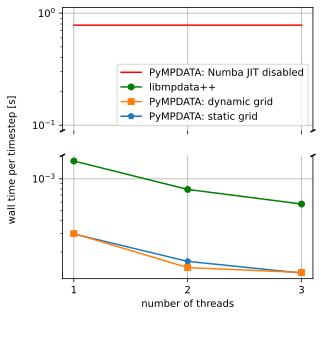

HTML(value="<a href='./fig_X.pdf' target='_blank'>./fig_X.pdf</a><br>")

In [9]:
fig, (ax1, ax2) = pyplot.subplots(2, 1, sharex=True, figsize=figsize)            
handles = []

for grid, marker in {'static': 'p', 'dynamic': 's'}.items():
    handles.append(ax2.plot(
        data_th_pympdata[grid].keys(),
        np.asarray(list(data_th_pympdata[grid].values())),
        label=f'PyMPDATA: {grid} grid',
        linewidth=linewidth, marker=marker
    )[0])
handles.append(ax2.plot(
    data_th_libmpdata.keys(),
    np.asarray(list(data_th_libmpdata.values())),
    label="libmpdata++",
    linewidth=linewidth, color='green', marker='o'
)[0])

x = list(data_th_pympdata['static'].keys())
handles.append(ax1.plot(
    x, 
    np.full((len(x),), data_th_pympdata['nojit']),
    label='PyMPDATA: Numba JIT disabled',
    linewidth=linewidth, color='red'
)[0])

ax1.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax1.tick_params(labeltop=False)
ax2.xaxis.tick_bottom()

d = .0075  # how big to make the diagonal lines in axes coordinates
# arguments to pass to plot, just so we don't keep repeating them
kwargs = {'transform': ax1.transAxes, 'color': 'k', 'clip_on': False}
ax1.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
ax1.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal

for ax in (ax1, ax2):
    ax.grid()
    ax.set_yscale('log')

ax1.legend(handles=handles[-1::-1], loc='lower right')

pyplot.xlabel("number of threads")
pyplot.ylabel("                                    wall time per timestep [s]\n")
show_plot('fig_X.pdf')

### 2. scaling with domain size

In [10]:
nxs = (8, 16, 32, 64, 128)

In [11]:
data_nx_libmpdata = {}
if sys.platform == 'linux':
    for nx in nxs:
        value = np.inf
        for _ in range(int(os.environ['N_REPEATS'])):
            info = subprocess.run(
                ["build/revolving_sphere_3d"],
                capture_output=True,
                check=True,
                env={
                    **os.environ,
                    "OMP_NUM_THREADS": os.environ['MAX_THREADS'],
                    "NX": str(nx),
                    "DT": str(float(os.environ['DT']) * float(os.environ['NX']) / nx)
                }
            )
            if info.returncode != 0:
                print(info)
                assert False
            value = min(value, float(str(info.stderr).split(" ")[3][:-1]))
        data_nx_libmpdata[nx] = value / int(os.environ['N_STEPS'])
print(data_nx_libmpdata)

{8: 0.000160728125, 16: 0.0005832375, 32: 0.00256853125, 64: 0.0168175, 128: 0.1908625}


In [12]:
from revolving_sphere_3d import time_pympdata  # pylint: disable=import-error

numba.set_num_threads(int(os.environ['MAX_THREADS']))

data_nx_pympdata = {}
for nx in nxs:
    dt = float(os.environ['DT']) * float(os.environ['NX']) / nx
    data_nx_pympdata[nx] = time_pympdata(
        static=False,
        n_threads=int(os.environ['MAX_THREADS']),
        nx=nx,
        dt=dt,
        nt=int(os.environ['N_STEPS']),
        repeat=int(os.environ['N_REPEATS'])
    )
print(data_nx_pympdata)

{8: 2.7577936490406355e-05, 16: 0.00015421887297951986, 32: 0.0008233078572499965, 64: 0.007012590190343972, 128: 0.057350292682669876}


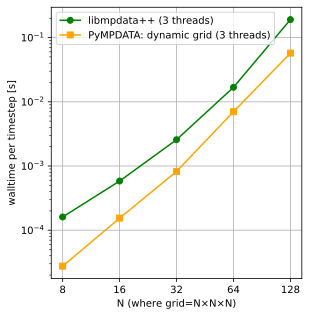

HTML(value="<a href='./fig_Y.pdf' target='_blank'>./fig_Y.pdf</a><br>")

In [13]:
fig, ax = pyplot.subplots(1, 1, figsize=figsize)  
ax.plot(
    data_nx_libmpdata.keys(),
    np.asarray(list(data_nx_libmpdata.values())),
    label=f"libmpdata++ ({os.environ['MAX_THREADS']} threads)",
    marker='o', color='green', linewidth=linewidth
)
ax.plot(
    data_nx_pympdata.keys(),
    np.asarray(list(data_nx_pympdata.values())),
    label=f"PyMPDATA: dynamic grid ({os.environ['MAX_THREADS']} threads)",
    marker='s', color='orange', linewidth=linewidth
)
ax.legend()
ax.set_yscale('log')
ax.set_xscale('log')
ax.xaxis.set_ticks(nxs, minor=False)
ax.xaxis.set_major_formatter(matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))
ax.xaxis.set_ticks([], minor=True)
ax.grid()
ax.set_ylabel('walltime per timestep [s]')
ax.set_xlabel('N (where grid=N$\\times$N$\\times$N)')
show_plot('fig_Y.pdf')